In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.086565e+09,868,1.251802e+06,612.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.179460e+08,582,5.462989e+05,2036.5
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,9.947018e+07,589,1.688798e+05,250.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,9.866908e+07,122,8.087629e+05,117035.5
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,9.195982e+07,197,4.668011e+05,500.0
5,,C00571703,CHEVRON CORPORATION,koch industries inc koch industries inc,Y4000,,NaN,NaN,WASHINGTON,TX,6.460129e+07,212,3.047231e+05,50000.0
6,,C00495028,CHC BOLD PAC,chc bold pac chc bold pac,Z9600,,NaN,NaN,WASHINGTON,DC,5.408387e+07,207,2.612747e+05,70000.0
7,,C00693382,FUND FOR POLICY REFORM,fund for policy reform fund for policy reform,J1200,,NaN,NaN,WILMINGTON,DE,4.950000e+07,7,7.071429e+06,6000000.0
8,,C00669259,FUTURE FORWARD USA ACTION,future forward usa action future forward usa a...,J1200,,NaN,NaN,WASHINGTON,DC,4.526326e+07,27,1.676417e+06,100000.0
9,,C00504530,AMERICAN ACTION NETWORK,american action network american action network,Z9600,,NaN,NaN,WASHINGTON,DC,4.465169e+07,138,3.235630e+05,100000.0


In [4]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
6211,P00013524,N00011042,Jo Jorgensen (L),L,PRES,,Y,Y,C,3L
6278,P00014209,N00042370,Don Blankenship (3),3,PRES,,Y,Y,C,3L
6934,P80000722,N00001669,Joe Biden (D),D,PRES,,Y,Y,C,DW
6936,P80001571,N00023864,Donald Trump (R),R,PRES,PRES,Y,Y,I,RL


In [5]:
cands[cands["recip_id"].str.contains("N")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
0,H0AK00105,N00039029,Thomas Lamb (I),I,AK01,,,Y,C,3N
1,H0AK00113,N00047445,Ray Sean Tugatuk (D),D,AK01,,,Y,C,DL
3,H0AL01055,N00044245,Jerry Carl (R),R,AL01,,Y,Y,O,RW
4,H0AL01063,N00044288,Wes Lambert (R),R,AL01,,,Y,O,RL
5,H0AL01071,N00025369,Chris Pringle (R),R,AL01,,,Y,O,RL
...,...,...,...,...,...,...,...,...,...,...
8055,S8WV00135,N00041474,Bo Copley (R),R,WVS1,,,,,RN
8056,S8WV00143,N00012642,Patrick Morrisey (R),R,WVS1,,,,,RN
8057,S8WY00189,N00027793,Gary Trauner (D),D,WYS1,,,,,DN
8058,S8WY00197,N00042998,David Dodson (R),R,WYS1,,,,,RN


In [6]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Party                    1299587
Unknown                  1036328
Ideology/Single Issue     861610
Health                    541522
Finance                   443132
Tech                      224719
Law                       199207
Construction              122016
Transportation            118605
Labor                     112626
Energy                     89268
Agribusiness               73594
Manufacturing              55259
Defense                    37952
Name: count, dtype: int64

In [7]:
preds = pd.read_csv(pred_csv)
donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
donors = donors.merge(cands, on='recip_id', how='left')

In [8]:
donors[~(donors["name_y"].isna())].sort_values(by=['total_donated'], ascending=False).iloc[:10][["name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
0,michael r bloomberg,Z9000,M,FOUNDER,NEW YORK,NY,1.086565e+09,Michael Bloomberg (D),D,PRES,C,DL
1,tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SAN FRANCISCO,CA,3.179460e+08,Tom Steyer (D),D,PRES,C,DL
2,information information requested,Y4000,,NaN,NEW YORK,CA,9.947018e+07,Joe Biden (D),D,PRES,C,DW
12,ion republ puiu,Y4000,,NaN,KEW GARDENS,CA,3.708834e+07,Donald Trump (R),R,PRES,I,RL
68,kathaleen wall,Z9000,F,RETIRED,HOUSTON,TX,5.971223e+06,Kathaleen Wall (R),R,TX22,O,RO
78,darrell issa - personal funds,Z9000,M,NaN,VISTA,CA,5.081387e+06,Darrell Issa (R),R,CA50,O,RW
88,mrs kreibich,X1200,,NaN,DENVER,CO,4.834415e+06,Mitch McConnell (R),R,KYS1,I,RW
122,sara jacobs,Z9000,F,SCHOLAR IN RESIDENCE,SAN DIEGO,CA,2.970613e+06,Sara Jacobs (D),D,CA53,O,DW
188,david trone,Z9000,M,CONGRESSMAN,BETHESDA,MD,1.695000e+06,David Trone (D),D,MD06,I,DW
201,joseph p iii kennedy,Z9000,M,REPRESENTATIVE,FOXBORO,MA,1.505000e+06,Joe Kennedy III (D),D,MAS2,C,DL


In [9]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
277,h3003465387,shiva ayyadurai,Z9000,U,CHAIRMAN & CEO,BELMONT,MA,1044900.0,Shiva Ayyadurai (R),R,MAS2,C,RL
7869,m0002196589,pathmanath desilva,T7000,U,CEO,TAMPA,FL,61821.0,Donald Trump (R),R,PRES,I,RL
8796,q0002067764,satish chandra,H1100,N,PHYSIAN,NEW YORK,NY,52920.0,Donald Trump (R),R,PRES,I,RL
11254,b0060468773,donna karan,Z9500,F,DESIGNER,NEW YORK,NY,48200.0,Joe Biden (D),D,PRES,C,DW
11784,r0019991585,barjinderjit singh,Z9600,U,CPA,PACIFICA,CA,45000.0,Donald Trump (R),R,PRES,I,RL
13219,b0608510336@,nalini mathur,H5150,F,RETIRED,HOUSTON,TX,39782.0,Donald Trump (R),R,PRES,I,RL
18396,r0016936800,bangar reddy,F2100,F,NaN,SUGAR LAND,TX,31984.0,Bangar Reddy Aaloori (R),R,TX22,O,RL
19745,p0005411243,farid khan,Y4000,M,HOTELIER,GILLETTE,WY,29500.0,Donald Trump (R),R,PRES,I,RL
19950,q00019578621,pritesh gandhi,Z9000,M,PHYSICIAN,AUSTIN,TX,29184.0,Pritesh Gandhi (D),D,TX10,C,DL
20830,q0000681742,philip thakadiyil,Z9500,M,CFO,WILLOW SPRINGS,IL,27000.0,Elizabeth Warren (D),D,MAS1,I,DI


In [10]:
donors[~(donors["name_y"].isna())].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    1223
R    1187
I      62
3      37
L      36
U       2
Name: count, dtype: int64

In [11]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    567
R    392
I      6
L      3
3      2
Name: count, dtype: int64

In [12]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')[["recip_id", "name_y", "party", "seat"]]

,recip_id,name_y,party,seat
51249,N00041312,Omar Siddiqui (D),D,CA48
96273,N00038290,Jan McDowell (D),D,TX24
126142,N00031005,Vicky Hartzler (R),R,MO04
130450,N00045057,Beth Parlato (R),R,NY27
131516,N00037442,Neal Dunn (R),R,FL02
...,...,...,...,...
7134783,N00043581,Ilhan Omar (D),D,MN05
7134865,N00041334,Theresa Greenfield (D),D,IAS2
7135395,N00046489,Raphael Warnock (D),D,GAS2
7135969,N00040675,Jon Ossoff (D),D,GAS1


In [13]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind") & (donors["state"] == "WY")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
19745,p0005411243,farid khan,Y4000,M,HOTELIER,GILLETTE,WY,29500.0,Donald Trump (R),R,PRES,I,RL
264293,m00014288021,king husein,B1500,M,CHAIRMAN,JACKSON,WY,5600.0,Donald Trump (R),R,PRES,I,RL
567698,m00014288021,king mr husein,B1500,M,CHAIRMAN AND CEO,JACKSON,WY,2800.0,Liz Cheney (R),R,WY01,I,RW
587626,m00014288021,king husein,B4400,M,ENGINEER,JACKSON,WY,2800.0,Kelly Loeffler (R),R,GAS2,I,RL
594586,m0001428802@,diane mrs husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,Liz Cheney (R),R,WY01,I,RW
609198,r0014730623,dharmesh patel,Y3000,M,SELF EMPLOYED,SHERIDAN,WY,2800.0,Joe Biden (D),D,PRES,C,DW
611358,m0001428802@,diane husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,Kelly Loeffler (R),R,GAS2,I,RL
615039,m0001428802@,diane husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,David Perdue (R),R,GAS1,I,RL
633997,m00014288021,king husein,B4400,M,ENGINEER,JACKSON,WY,2800.0,David Perdue (R),R,GAS1,I,RL
4460840,m00014288021,king husein,B1500,M,FOUNDER / CEO,JACKSON,WY,250.0,TJ Cox (D),D,CA21,I,DL


In [14]:
# 2020: 5.8 billion vs 38.5 million
print("Overall:", donors[~(donors["name_y"].isna())]["total_donated"].sum())
print("Indians:", donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())

Overall: 5062218859.0
Indians: 31919209.0


In [15]:
print("Finance:", donors[(donors["sector"] == "Finance") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Finance, Indian:", donors[(donors["sector"] == "Finance") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Tech:", donors[(donors["sector"] == "Tech") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Tech, Indian:", donors[(donors["sector"] == "Tech") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Health:", donors[(donors["sector"] == "Health") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Healthm Indian:", donors[(donors["sector"] == "Health") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())

Finance: 331045881.0
Finance, Indian: 3026572.0
Tech: 123597963.0
Tech, Indian: 1356277.0
Health: 219160598.0
Healthm Indian: 3736030.0


In [16]:
state_stats = (
    donors.groupby(["state", "party"])
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,party,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,NY,D,6059.811708,500.0,1.381164e+09,227922,1663.366041,705.0,3458138.0,2079
1,CA,D,1995.458349,500.0,8.979962e+08,450020,1324.705976,500.0,5807511.0,4384
2,CA,R,1174.859015,300.0,1.766307e+08,150342,1314.176638,503.0,922552.0,702
3,TX,R,1087.027809,425.0,1.528394e+08,140603,1420.296569,500.5,579481.0,408
4,MA,D,1185.397902,500.0,1.430870e+08,120708,1359.031746,500.0,1027428.0,756
5,TX,D,1040.455660,450.0,1.195338e+08,114886,1419.417768,550.5,1933247.0,1362
6,FL,R,1013.877811,363.0,1.140339e+08,112473,1461.481183,500.0,543671.0,372
7,FL,D,939.639916,349.0,8.868134e+07,94378,1340.436464,500.0,727857.0,543
8,IL,D,979.936067,500.0,8.781109e+07,89609,1489.028249,550.0,1581348.0,1062
9,WA,D,834.298503,333.0,7.926170e+07,95004,1467.478947,500.0,836463.0,570


In [17]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [18]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [19]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

In [20]:
state_pivot = state_stats.pivot(index='state', columns='party', values='total_donations').fillna(0)
state_pivot['total'] = state_pivot['D'] + state_pivot['R']
state_pivot['dem_ratio'] = state_pivot['D'] / state_pivot['total']

state_pivot_indian = state_stats.pivot(index='state', columns='party', values='total_donations_indian').fillna(0)
state_pivot_indian['total'] = state_pivot_indian['D'] + state_pivot_indian['R']
state_pivot_indian['dem_ratio'] = state_pivot_indian['D'] / state_pivot_indian['total']

ratio = gdf.merge(state_pivot, left_on='state', right_index=True, how='left')
ratio_indian = gdf.merge(state_pivot_indian, left_on='state', right_index=True, how='left')


In [38]:
state_pivot_indian[state_pivot_indian["dem_ratio"] < 0.7]

party,3,D,I,L,R,U,total,dem_ratio
state,,,,,,,,
,0.0,4800.0,0.0,0.0,6550.0,0.0,11350.0,0.422907
AE,0.0,0.0,0.0,0.0,35.0,0.0,35.0,0.000000
AL,0.0,48792.0,842.0,0.0,52018.0,0.0,100810.0,0.484000
AR,0.0,10257.0,631.0,0.0,8275.0,0.0,18532.0,0.553475
FL,0.0,727857.0,31077.0,0.0,543671.0,0.0,1271528.0,0.572427
GA,0.0,598974.0,18256.0,0.0,270816.0,0.0,869790.0,0.688642
ID,0.0,1982.0,390.0,0.0,4076.0,0.0,6058.0,0.327171
KY,0.0,36465.0,5873.0,0.0,21155.0,0.0,57620.0,0.632853
LA,0.0,70010.0,1064.0,0.0,43279.0,0.0,113289.0,0.617977


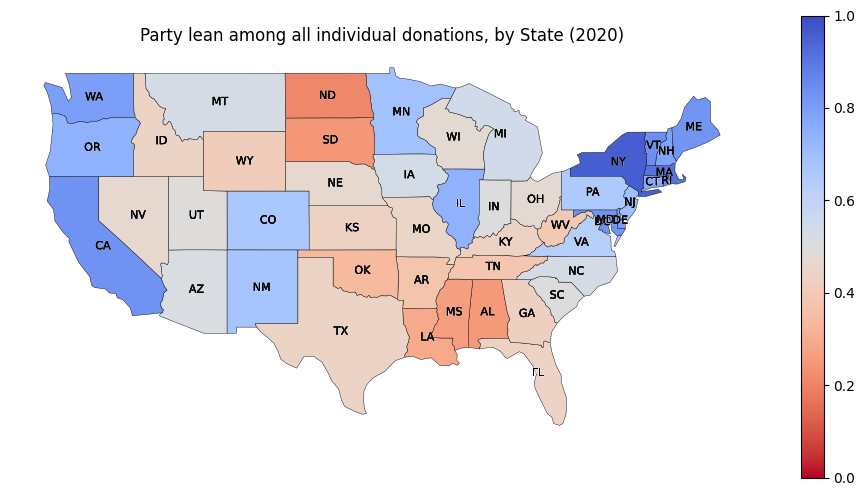

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio.plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all individual donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

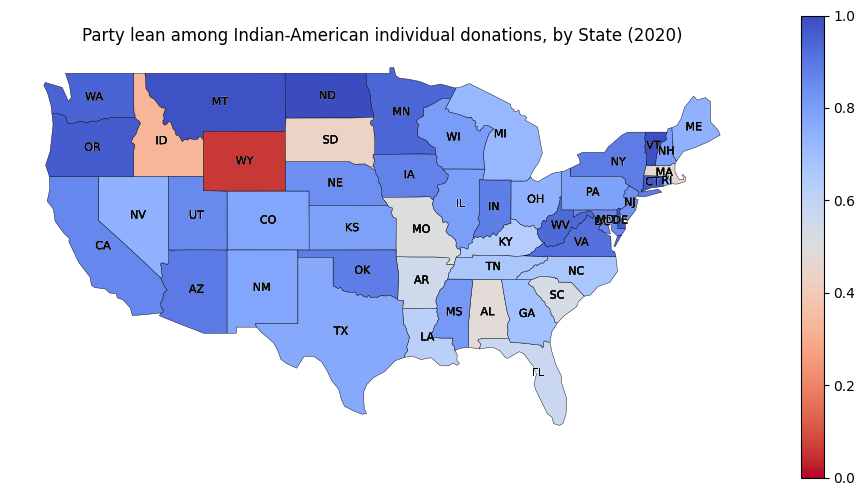

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian.plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American individual donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [31]:
sector_stats = (
    donors[~(donors["sector"].isin(["Ideology/Single Issue", "Party", "Unknown"]))].groupby(["state", "sector", "party"])["total_donated"]
    .sum()
    .unstack()
    .fillna(0)
)
sector_stats["total_donated"] = sector_stats["D"] + sector_stats["R"]
sector_stats["dem_ratio"] = sector_stats["D"] / (sector_stats["D"] + sector_stats["R"])
sector_stats = sector_stats.sort_values(by="total_donated", ascending=False).reset_index()
sector_stats

party,state,sector,3,D,I,L,R,U,total_donated,dem_ratio
0,NY,Finance,10822.0,46291938.0,676769.0,16795.0,15675974.0,0.0,61967912.0,0.747031
1,CA,Finance,6778.0,33985744.0,958777.0,30300.0,20585901.0,0.0,54571645.0,0.622773
2,CA,Tech,17522.0,39786065.0,3863769.0,35828.0,3519833.0,0.0,43305898.0,0.918722
3,CA,Health,9752.0,25804520.0,3083485.0,9900.0,6713216.0,0.0,32517736.0,0.793552
4,TX,Finance,750.0,8220490.0,322605.0,28493.0,22322188.0,0.0,30542678.0,0.269148
...,...,...,...,...,...,...,...,...,...,...
631,ND,Labor,0.0,0.0,1599.0,20.0,0.0,0.0,0.0,NaN
632,MP,Finance,0.0,0.0,500.0,0.0,0.0,0.0,0.0,NaN
633,AP,Transportation,0.0,0.0,189.0,0.0,0.0,0.0,0.0,NaN
634,VT,Labor,0.0,0.0,1054.0,0.0,0.0,0.0,0.0,NaN


In [32]:
sector_stats_indian = (
    donors[~(donors["sector"].isin(["Ideology/Single Issue", "Party", "Unknown"])) & (donors["ethnic"] == "ind")].groupby(["state", "sector", "party"])["total_donated"]
    .sum()
    .unstack()
    .fillna(0)
)
sector_stats_indian["total_donated"] = sector_stats_indian["D"] + sector_stats_indian["R"]
sector_stats_indian["dem_ratio"] = sector_stats_indian["D"] / (sector_stats_indian["D"] + sector_stats_indian["R"])
sector_stats_indian = sector_stats_indian.sort_values(by="total_donated", ascending=False).reset_index()
sector_stats_indian

party,state,sector,3,D,I,L,R,total_donated,dem_ratio
0,CA,Finance,500.0,767847.0,8362.0,250.0,191609.0,959456.0,0.800294
1,NY,Finance,0.0,796467.0,1578.0,0.0,71024.0,867491.0,0.918127
2,CA,Health,0.0,526193.0,59095.0,0.0,160574.0,686767.0,0.766189
3,CA,Tech,0.0,440614.0,61838.0,0.0,30676.0,471290.0,0.934911
4,NY,Health,0.0,261267.0,20122.0,0.0,157766.0,419033.0,0.623500
...,...,...,...,...,...,...,...,...,...
335,OK,Tech,0.0,0.0,108.0,0.0,0.0,0.0,NaN
336,WY,Health,0.0,0.0,77.0,0.0,0.0,0.0,NaN
337,MA,Labor,0.0,0.0,77.0,0.0,0.0,0.0,NaN
338,SC,Tech,0.0,0.0,324.0,0.0,0.0,0.0,NaN


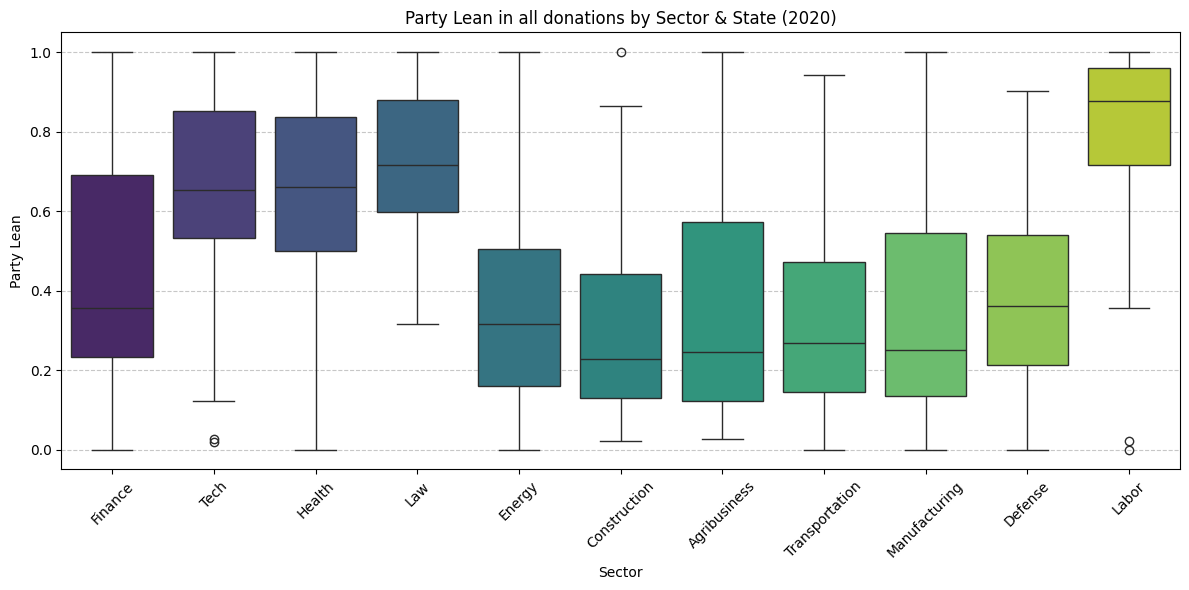

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sector_stats, x="sector", y="dem_ratio", palette="viridis")
plt.xticks(rotation=45)
plt.title(f"Party Lean in all donations by Sector & State (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

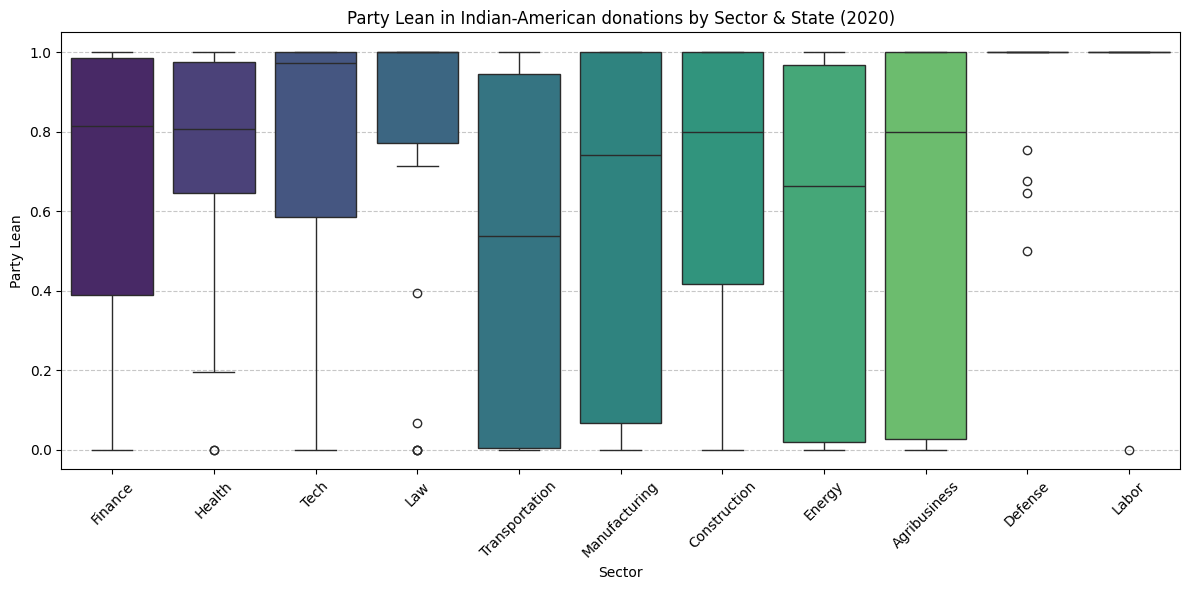

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sector_stats_indian, x="sector", y="dem_ratio", palette="viridis")
plt.xticks(rotation=45)
plt.title(f"Party Lean in Indian-American donations by Sector & State (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()